# Calibrating the ZP of R and r images #

The goal is to bootstrap the zeropoint of our R and r-band images using photometric catalogs from Pan-STARRS.

We are using test images from 2015-04-18 taken with the HDI camera on KPNO 0.9m telescope

Ideally, we will also get the flux calibration for the Halpha image.

If the data were taken through the Johnson R filter, we will need to covert the Pan-STARRS r magnitudes to R.







# NOTES #

### Basic Steps For Program getzp.py ###

* Run Source Extractor on image to measure magnitudes
* Read in Source Extractor catalog
* get max/min RA and DEC for the image
* get Pan-STARRS catalog over the same region
* match Pan-STARRS1 data to Source Extractor sources
* remove any objects that are saturated or non-linear in our r-band image
* Solve for the zeropoint


### Data Checks ###
* HDI nonlinearity kicks in by 40k counts
* need to check raw counts of R and Halpha images for the 180 and 20 min exposures
* make sure the sources we are using are not saturated.
* check if units of mosaic are ADU/s



### Improvements to Code ###
* implemented scipy.optimize.curve_fit in getzp.py to 
    * keep slope fixed at 1
    * this allows us to get an estimate of error in ZP (sqrt(covariance))
    
* now using SExtractor aperture magnitudes rather than MAG_AUTO.  The user can select which aperture number to use using the --naper command line argument.  Right now, in default.sex.HDI, I request aperture magnitudes of  5,10,12,15,20,25 pixel diameter.  The default value for --naper is 4, which corresponds to the 20 pix diameter aperture.  I just realized this is diameter rather than radius, so these values might not be large enough.  I'll wait for the comparison with Becky before exploring this further, but if FWHM is typically 4-5 pixels, then is a 25-pixel diameter aperture large enough?
* expanded the above apertures.  default is now a 30 pix diam aperture.
* changed rejection algorithm to use the median absolute deviation rather than standard deviation.  this should perform better when there are extreme outliers in the data.


### AB vs Vega Magnitudes ###

To convert from Vega to AB zeropoint, use conversion from Blanton+2007, which is listed at
http://www.astronomy.ohio-state.edu/~martini/usefuldata.html

$ ZP_{AB} = ZP_{Vega} +.21$

## Comparing with Standard Stars ##

As a test, I want to calibrate the standard star images, and then measure the magnitudes of the standard stars.

I apparently moved a number of the standard star files to junk, so I will need to reduce these images through flatfielding.

I copied all standard files from raw directory:

```
cp ../../../rawdata/20150418/c7131t00{19..25}o00.fits standards_raw/
cp ../../../rawdata/20150418/c7131t00{70..74}o00.fits standards_raw/.
```

The reduction is detailed in the notebook reduction-of-standard-star-images.ipynb




## Checking Magnitudes of Standard Stars ##

From Becky:

```
# FIELD     FILTER  OTIME   AIRMASS  XCENTER   YCENTER  MAG   MERR
PG0918+029A   R   02:40:12     1.151   2071.654  1732.055  15.960  0.013 
PG0918+029B   R   02:40:12     1.151   2151.200  1964.721  15.335  0.008 
PG0918+029C   R   02:40:12     1.151   1819.131  1776.168  14.979  0.006 
PG0918+029D   R   02:40:12     1.151   2537.494  1889.052  13.498  0.002 
PG0918+029    R   02:40:12     1.151   2314.763  1688.586  15.251  0.007 
RU_149A       R   02:43:25     1.308    2172.032  2011.177  16.190  0.016
RU_149B       R   02:43:25     1.308    2018.314  1981.408  14.089  0.003
RU_149C       R   02:43:25     1.308    2028.162  2076.732  16.101  0.015
RU_149D       R   02:43:25     1.308    2095.895  2024.223  13.283  0.002
RU_149E       R   02:43:25     1.308    1991.068  2235.042  15.207  0.007
RU_149F       R   02:43:25     1.308    2143.203  2186.315  14.707  0.005
RU_149G       R   02:43:25     1.308    2218.802  2139.711  14.334  0.004
RU_149        R   02:43:25     1.308    2172.032  2011.177  16.190  0.016
PG1528+062A   R    11:50:34    1.433    2124.965  2059.521  16.876  0.016
PG1528+062B   R    11:50:34    1.433    2459.723  2029.408  13.462  0.002
PG1528+062    R    11:50:34    1.433    2094.694  1993.606  16.689  0.013
PG1633+099A   R    11:53:52    1.18     2016.623  2014.445  16.548  0.008
PG1633+099B   R    11:53:52    1.18     1759.578  1800.097  14.182  0.002
PG1633+099C   R    11:53:52    1.18     1621.906  1790.770  14.410  0.002
PG1633+099D   R    11:53:52    1.18     1524.724  1852.141  15.153  0.003
PG1633+099    R    11:53:52    1.18     2085.292  2005.930  16.285  0.007

```


Becky suggested to focus on Landolt standards only, and to not include the spectrophotometric standards.  She sent the above list, although the positions of the stars in my images are different (not sure why).

* I found the finding charts and V and V-R magnitudes for the landolt standards at

https://www.cfht.hawaii.edu/ObsInfo/Standards/Landolt/

* I then recorded the positions of the stars in the file **mystandards.csv**.

* I wrote another program to pull out the measured photometry for each standard star - **dbug_getzp.py**.  This allows me to make changes in getzp.py and then compare the measured vs known magnitudes of the landolt standards.



In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import ascii
%matplotlib inline


In [2]:
os.chdir('/Users/rfinn/research/HalphaGroups/reduced_data/HDI/20150418/standards_raw/')


In [6]:
stand = ascii.read('mystandards.csv', delimiter=',')

In [8]:
print(stand)

          IMAGE             STANDARD    V    V-R     R    XIMAGE YIMAGE
------------------------- ----------- ----- ------ ------ ------ ------
nshdztrc7131t0019o00.fits PG0918+029A 14.49  0.325 14.165   2024   1731
nshdztrc7131t0019o00.fits PG0918+029B 13.96  0.417 13.543   1945   1964
nshdztrc7131t0019o00.fits PG0918+029C 13.54  0.367 13.173   2277   1775
nshdztrc7131t0019o00.fits PG0918+029D 12.27  0.575 11.695   1558   1888
nshdztrc7131t0019o00.fits  PG0918+029 13.33 -0.129 13.459   1781   1688
nshdztrc7131t0020o00.fits     RU_149A  14.5  0.196 14.304   1924   2011
nshdztrc7131t0020o00.fits     RU_149B 12.64  0.374 12.266   2078   1981
nshdztrc7131t0020o00.fits     RU_149C 14.43  0.093 14.337   2068   2076
nshdztrc7131t0020o00.fits     RU_149D 11.48  0.021 11.459   2000   2024
nshdztrc7131t0020o00.fits     RU_149E 13.72  0.321 13.399   2105   2234
nshdztrc7131t0020o00.fits     RU_149F 13.47  0.594 12.876   1952   2186
nshdztrc7131t0020o00.fits     RU_149G 12.83  0.322 12.508   1878

In [25]:
len(stand)

21

## SDSS filter transformation doesn't work ##


The transformations from SDSS r to Johnson R are:

$$ R-r   =  (-0.153 \pm 0.003)(r-i) - (0.117 \pm 0.003) $$

or 

$$ R   =  r + (-0.153 \pm 0.003)(r-i) - (0.117 \pm 0.003) $$

http://www.sdss3.org/dr8/algorithms/sdssUBVRITransform.php#Jordi2006

NOTE: This is not the relationship to use to convert from Pan-STARRS r to Johnson R.  See below.

The SDSS filter transformation leads to a systematic offset of around 0.08 between measured and Landolt magnitudes.


### Trying other magnitudes ###

* I tried using --filter r flag, and this made the offset worse (dm > 0.2 mag).

* I tried aperture magnitudes - 

* I tried switching to petro magnitudes  - this changes the zeropoint, but the final mags are about the same.  The median offset in measured - landolt is around 0.08 mag.

## pan-starrs references ##

* https://vizier.u-strasbg.fr/viz-bin/VizieR?-source=II/349 - details on catalog

* https://arxiv.org/pdf/1612.05242.pdf

* this website says kron radius does not enclose total flux and you should expect 10% of flux to be missing.  this is consistent with what I am measuring, I think?

* https://iopscience.iop.org/article/10.1088/0067-0049/205/2/20

* **Transformation of Pan-STARRS1 gri
to Stetson BVRI magnitudes.
Photometry of small bodies observations.** https://arxiv.org/pdf/1706.06147.pdf 



# updated code to use new conversion from gunn to Johnson filters. #


This was hugely useful!  brought the discrepancy down to < 0.02 mag




However, it seems like the two conversions from r to R (one uses g-r and the other uses r-i) give different zeropoints.





## Solving for Zeropoint ##

Now ready to solve for ZP of images.  Going to focus on R-band images first

| Filename | Standard | SECZ | NPOINTS  | 
|----------|----------|-----|-----------|
|shdztrc7131t0019o00.fits | PG 918 | 1.151 | 63 |
| shdztrc7131t0020o00.fits | RU 149 | 1.308 | 317 |
| shdztrc7131t0022o00.fits | Feige 34 | 1.1 | 41 |
|shdztrc7131t0072o00.fits| BD+33 | 1.0 | 39 |
|shdztrc7131t0073o00.fits | PG 1528| 1.433 | 99 |
|shdztrc7131t0074o00.fits | PG 1633 | 1.18 | 175 |



## MAG_APER4 and using g-r relation ##

Aperture magnitudes, g-r conversion from r to R (Kostov & Bonov)

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
os.chdir('/Users/rfinn/research/HalphaGroups/reduced_data/HDI/20150418/standards_raw/')


nshdztrc7131t0019o00.fits
saturation limit in ADU/s 5000.0


//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Using Aperture Magnitudes
number of points retained =  --
new ZP = 0.000, previous ZP = -23.545
number of points retained =  60
new ZP = -23.545, previous ZP = -23.504
number of points retained =  56
new ZP = -23.504, previous ZP = -23.504
working on this
ZP = 23.504 +/- 0.002
nshdztrc7131t0020o00.fits
saturation limit in ADU/s 5714.3


//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Using Aperture Magnitudes
number of points retained =  --
new ZP = 0.000, previous ZP = -24.083
number of points retained =  340
new ZP = -24.083, previous ZP = -23.485
number of points retained =  330
new ZP = -23.485, previous ZP = -23.482
number of points retained =  322
new ZP = -23.482, previous ZP = -23.482
working on this
ZP = 23.482 +/- 0.001
nshdztrc7131t0073o00.fits
saturation limit in ADU/s 5714.3


//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Using Aperture Magnitudes
number of points retained =  --
new ZP = 0.000, previous ZP = -24.278
number of points retained =  112
new ZP = -24.278, previous ZP = -23.470
number of points retained =  103
new ZP = -23.470, previous ZP = -23.468
number of points retained =  97
new ZP = -23.468, previous ZP = -23.466
number of points retained =  97
new ZP = -23.466, previous ZP = -23.466
working on this
ZP = 23.466 +/- 0.002
nshdztrc7131t0074o00.fits
saturation limit in ADU/s 3076.9


//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Using Aperture Magnitudes
number of points retained =  --
new ZP = 0.000, previous ZP = -23.787
number of points retained =  198
new ZP = -23.787, previous ZP = -23.509
number of points retained =  191
new ZP = -23.509, previous ZP = -23.508
working on this
ZP = 23.508 +/- 0.001


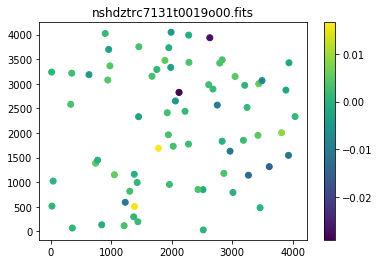

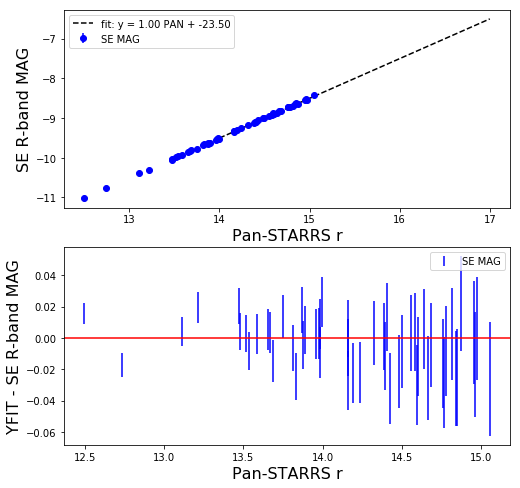

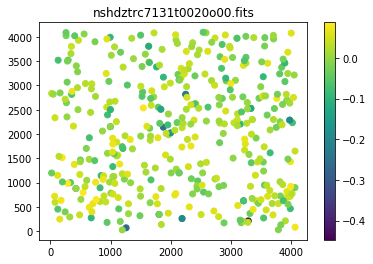

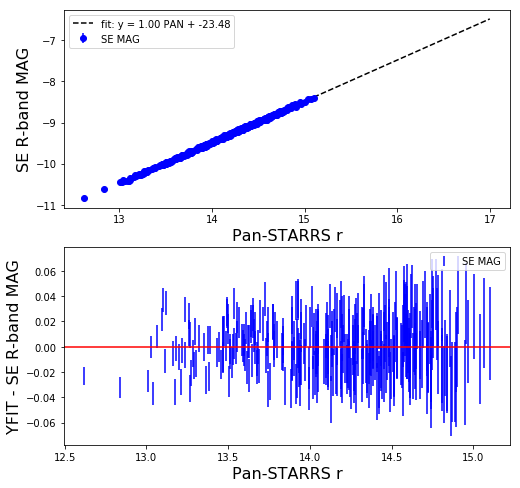

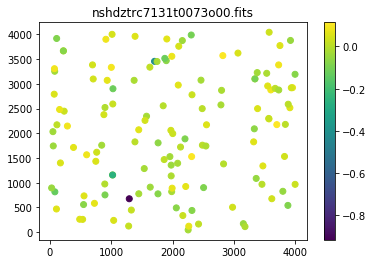

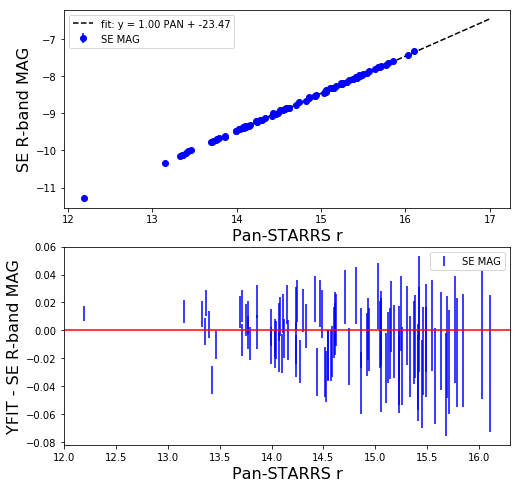

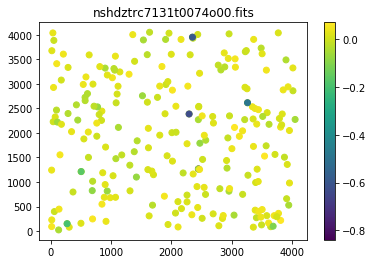

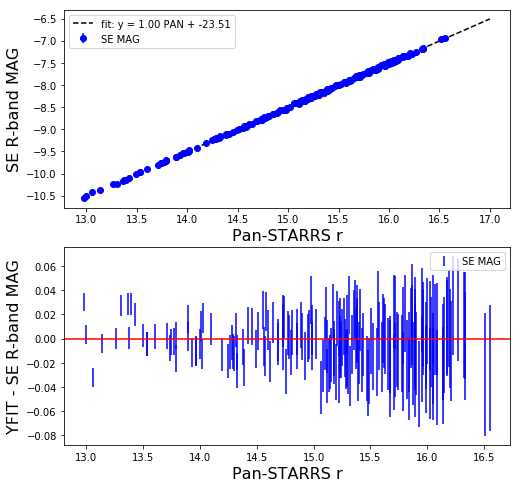

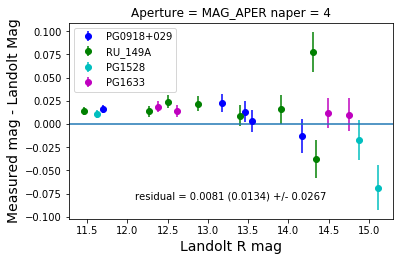

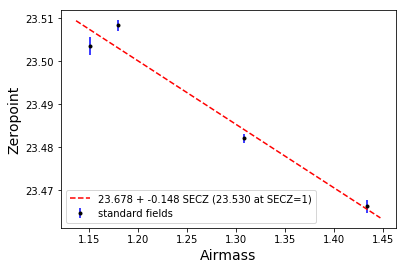

In [17]:
%run ~/github/HalphaImaging/dbug_getzp.py  --fitzp --mag 0 --naper 4 --nsigma 2.


In [27]:
zpdict

{'nshdztrc7131t0019o00.fits': 23.503527,
 'nshdztrc7131t0020o00.fits': 23.482225,
 'nshdztrc7131t0073o00.fits': 23.468754,
 'nshdztrc7131t0074o00.fits': 23.506504}

In [28]:
t=[]
for z in zpdict: t.append(zpdict[z])
print(np.mean(t))

23.490253


## MAG_APER4 and r-i conversion ##

aperture mag with 30 pixel diameter and r-i conversion from r to R (Kostov & Bonov)

In [10]:
%run ~/github/HalphaImaging/dbug_getzp.py --fitzp --useri --mag 0 --naper 4 --nsigma 2.

nshdztrc7131t0019o00.fits
saturation limit in ADU/s 5000.0
sex nshdztrc7131t0019o00.fits -c default.sex.HDI -CATALOG_NAME nshdztrc7131t0019o00.cat -MAG_ZEROPOINT 0 -SATUR_LEVEL 5000.0


//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


Using Aperture Magnitudes
number of points retained =  --
new ZP = 0.000, previous ZP = -23.517
number of points retained =  62
new ZP = -23.517, previous ZP = -23.404
number of points retained =  60
new ZP = -23.404, previous ZP = -23.404
working on this
nshdztrc7131t0020o00.fits
saturation limit in ADU/s 5714.3
sex nshdztrc7131t0020o00.fits -c default.sex.HDI -CATALOG_NAME nshdztrc7131t0020o00.cat -MAG_ZEROPOINT 0 -SATUR_LEVEL 5714.285714285715


//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


Using Aperture Magnitudes
number of points retained =  --
new ZP = 0.000, previous ZP = -23.556
number of points retained =  338
new ZP = -23.556, previous ZP = -23.393
number of points retained =  319
new ZP = -23.393, previous ZP = -23.388
number of points retained =  313
new ZP = -23.388, previous ZP = -23.388
working on this
nshdztrc7131t0073o00.fits
saturation limit in ADU/s 5714.3
sex nshdztrc7131t0073o00.fits -c default.sex.HDI -CATALOG_NAME nshdztrc7131t0073o00.cat -MAG_ZEROPOINT 0 -SATUR_LEVEL 5714.285714285715


//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


Using Aperture Magnitudes
number of points retained =  --
new ZP = 0.000, previous ZP = -23.397
number of points retained =  80
new ZP = -23.397, previous ZP = -23.375
number of points retained =  77
new ZP = -23.375, previous ZP = -23.374
number of points retained =  75
new ZP = -23.374, previous ZP = -23.374
working on this
nshdztrc7131t0074o00.fits
saturation limit in ADU/s 3076.9
sex nshdztrc7131t0074o00.fits -c default.sex.HDI -CATALOG_NAME nshdztrc7131t0074o00.cat -MAG_ZEROPOINT 0 -SATUR_LEVEL 3076.923076923077


//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


Using Aperture Magnitudes
number of points retained =  --
new ZP = 0.000, previous ZP = -23.472
number of points retained =  93
new ZP = -23.472, previous ZP = -23.417
number of points retained =  85
new ZP = -23.417, previous ZP = -23.412
number of points retained =  83
new ZP = -23.412, previous ZP = -23.412
working on this


In [18]:
plt.show()

In [12]:
zpdict

{'nshdztrc7131t0019o00.fits': 23.403906,
 'nshdztrc7131t0020o00.fits': 23.387526,
 'nshdztrc7131t0073o00.fits': 23.37387,
 'nshdztrc7131t0074o00.fits': 23.411968}

In [26]:
len(residual)

21

### The g-r calibration is better and we should use this. ###


* The r-i relation does not work as well - gives systematic offset in measured - landolt mag of:

$$R_{measured} - R_{landolt} = -0.0878 \pm 0.0263$$

* The g-r relation gives a smaller systematic offset in the measured magnitude:

$$R_{measured} - R_{landolt} = 0.0080 \pm 0.0262$$

* The dispersion is similar for both relationships.


## Trying MAG_BEST ##

this is what we will use to measure galaxy magnitudes, probably.  

Although we are also measuring flux in elliptical apertures, so maybe that argues for the aperture magnitudes?

Anyway, trying MAG_BEST to see if the residuals and scatter are similar.



nshdztrc7131t0019o00.fits
saturation limit in ADU/s 5000.0


//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Using MAG_BEST
number of points retained =  --
new ZP = 0.000, previous ZP = -23.486
number of points retained =  58
new ZP = -23.486, previous ZP = -23.445
number of points retained =  52
new ZP = -23.445, previous ZP = -23.441
number of points retained =  49
new ZP = -23.441, previous ZP = -23.441
working on this
ZP = 23.441 +/- 0.001
nshdztrc7131t0020o00.fits
saturation limit in ADU/s 5714.3


//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Using MAG_BEST
number of points retained =  --
new ZP = 0.000, previous ZP = -23.932
number of points retained =  336
new ZP = -23.932, previous ZP = -23.423
number of points retained =  322
new ZP = -23.423, previous ZP = -23.422
number of points retained =  318
new ZP = -23.422, previous ZP = -23.421
working on this
ZP = 23.421 +/- 0.001
nshdztrc7131t0073o00.fits
saturation limit in ADU/s 5714.3


//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Using MAG_BEST
number of points retained =  --
new ZP = 0.000, previous ZP = -24.154
number of points retained =  112
new ZP = -24.154, previous ZP = -23.408
number of points retained =  109
new ZP = -23.408, previous ZP = -23.407
working on this
ZP = 23.407 +/- 0.002
nshdztrc7131t0074o00.fits
saturation limit in ADU/s 3076.9


//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Using MAG_BEST
number of points retained =  --
new ZP = 0.000, previous ZP = -23.719
number of points retained =  204
new ZP = -23.719, previous ZP = -23.447
number of points retained =  201
new ZP = -23.447, previous ZP = -23.446
number of points retained =  199
new ZP = -23.446, previous ZP = -23.445
working on this
ZP = 23.445 +/- 0.001


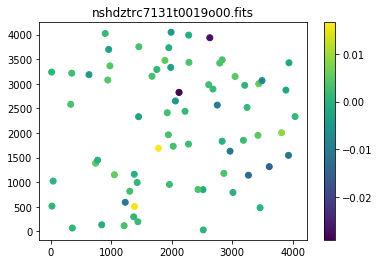

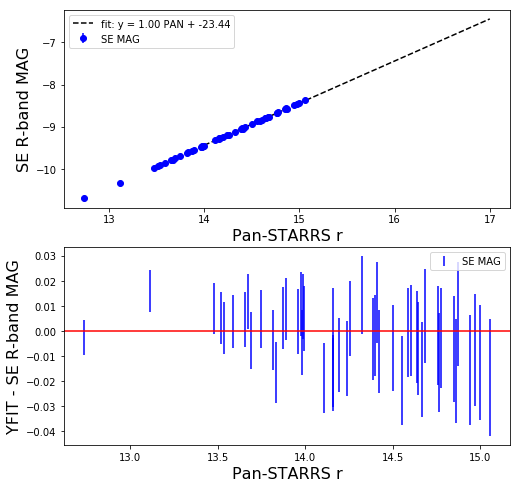

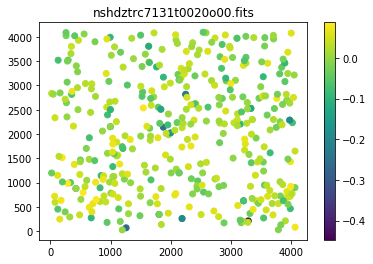

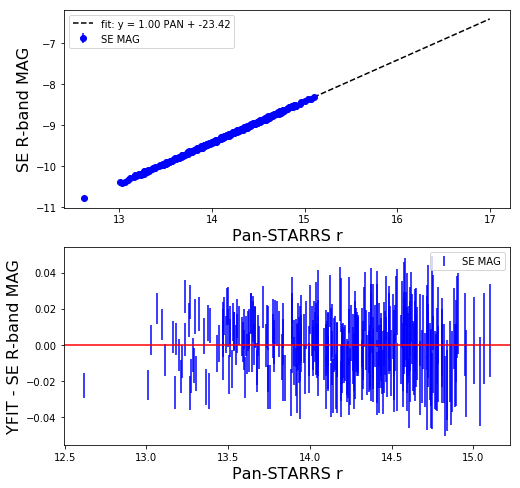

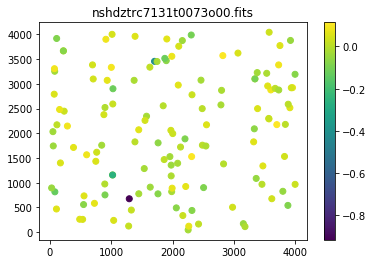

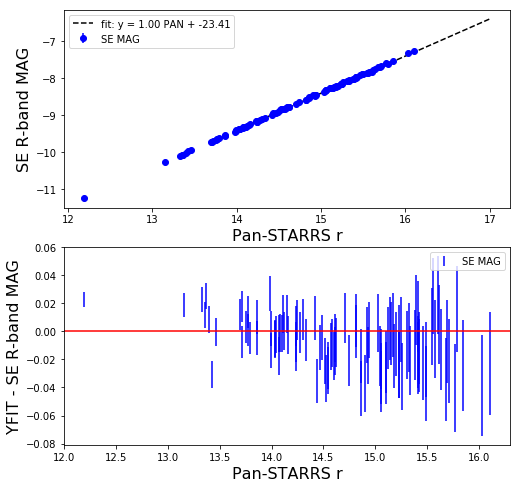

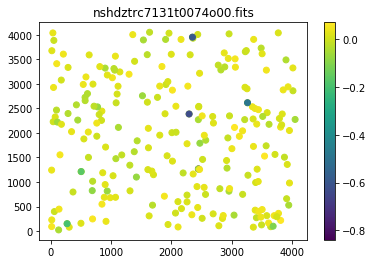

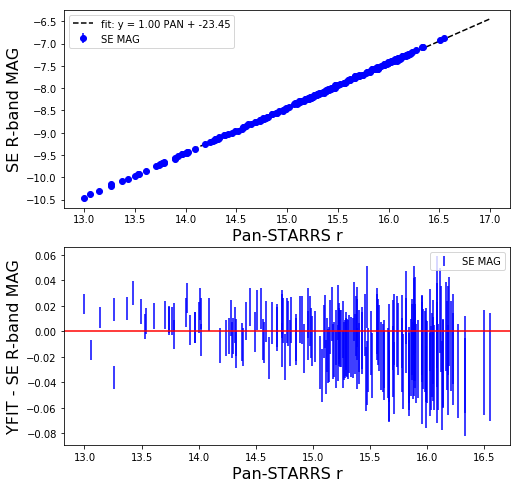

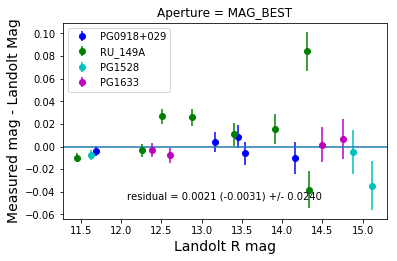

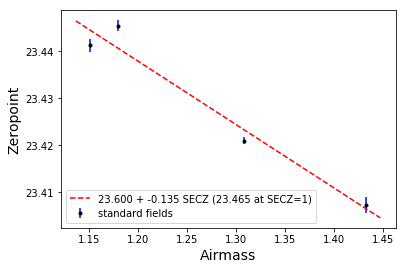

In [19]:
# using mag_best
%run ~/github/HalphaImaging/dbug_getzp.py --fitzp --mag 1 --nsigma 2

In [15]:
zpdict

{'nshdztrc7131t0019o00.fits': 23.441275,
 'nshdztrc7131t0020o00.fits': 23.42151,
 'nshdztrc7131t0073o00.fits': 23.40818,
 'nshdztrc7131t0074o00.fits': 23.449934}

In [29]:
np.mean([23.441275,23.42151,23.40818,23.449934])

23.43022475

## Trying petro mag ##



In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
os.chdir('/Users/rfinn/research/HalphaGroups/reduced_data/HDI/20150418/standards_raw/')


nshdztrc7131t0019o00.fits
saturation limit in ADU/s 5000.0


//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Using MAG_PETRO
number of points retained =  --
new ZP = 0.000, previous ZP = -23.512
number of points retained =  57
new ZP = -23.512, previous ZP = -23.477
number of points retained =  56
new ZP = -23.477, previous ZP = -23.477
working on this
ZP = 23.477 +/- 0.002
nshdztrc7131t0020o00.fits
saturation limit in ADU/s 5714.3


//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Using MAG_PETRO
number of points retained =  --
new ZP = 0.000, previous ZP = -24.001
number of points retained =  335
new ZP = -24.001, previous ZP = -23.462
number of points retained =  309
new ZP = -23.462, previous ZP = -23.461
working on this
ZP = 23.461 +/- 0.001
nshdztrc7131t0073o00.fits
saturation limit in ADU/s 5714.3


//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Using MAG_PETRO
number of points retained =  --
new ZP = 0.000, previous ZP = -24.189
number of points retained =  110
new ZP = -24.189, previous ZP = -23.439
number of points retained =  102
new ZP = -23.439, previous ZP = -23.438
number of points retained =  100
new ZP = -23.438, previous ZP = -23.438
working on this
ZP = 23.438 +/- 0.001
nshdztrc7131t0074o00.fits
saturation limit in ADU/s 3076.9


//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Using MAG_PETRO
number of points retained =  --
new ZP = 0.000, previous ZP = -23.739
number of points retained =  206
new ZP = -23.739, previous ZP = -23.472
number of points retained =  196
new ZP = -23.472, previous ZP = -23.470
number of points retained =  195
new ZP = -23.470, previous ZP = -23.470
working on this
ZP = 23.470 +/- 0.001


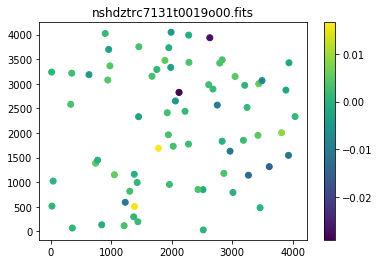

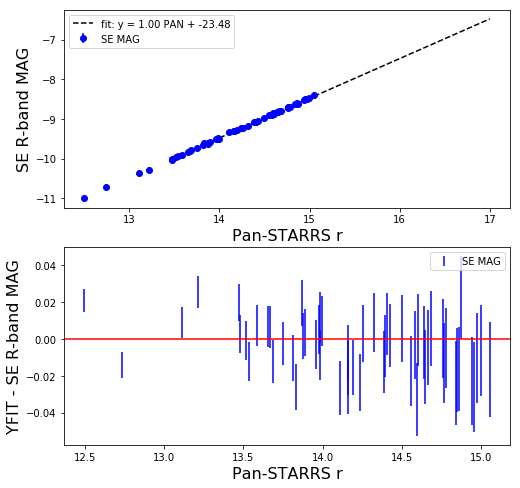

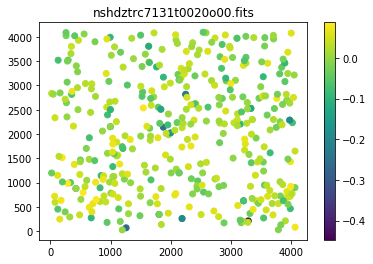

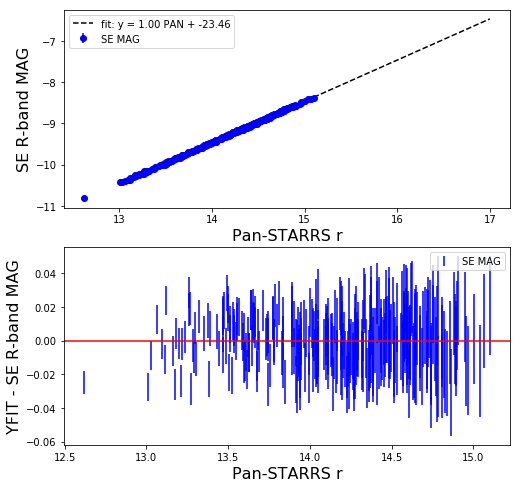

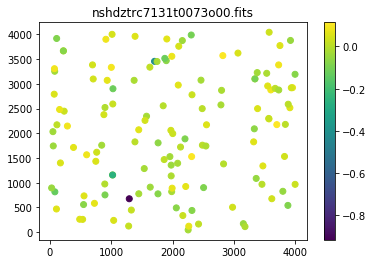

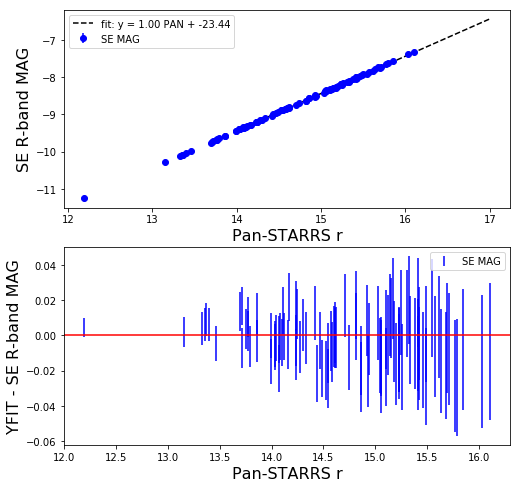

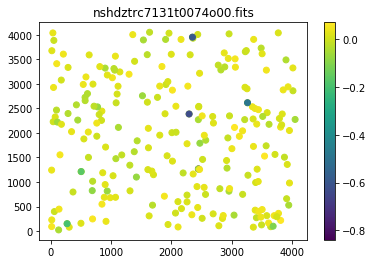

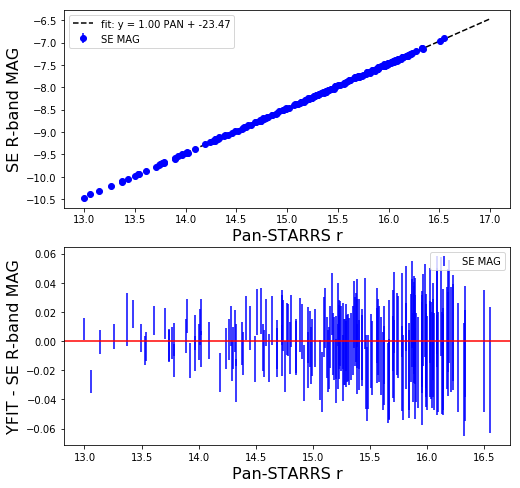

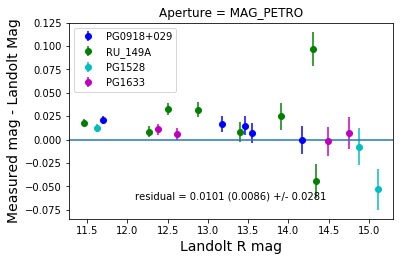

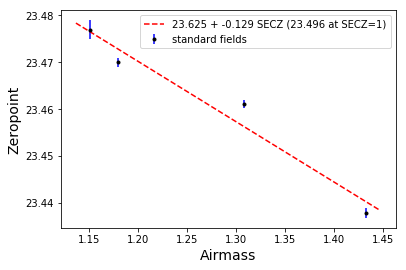

In [20]:
# using mag_best
%run ~/github/HalphaImaging/dbug_getzp.py --fitzp --mag 2 --nsigma 2

In [18]:
zpdict

{'nshdztrc7131t0019o00.fits': 23.476955,
 'nshdztrc7131t0020o00.fits': 23.461155,
 'nshdztrc7131t0073o00.fits': 23.438576,
 'nshdztrc7131t0074o00.fits': 23.471321}

In [30]:
np.mean([23.476955,23.461155,23.438576,23.471321])

23.462001750000002

# Trying Aperture Mag 5 (30 pix diam) #


nshdztrc7131t0019o00.fits
saturation limit in ADU/s 5000.0


//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Using Aperture Magnitudes
number of points retained =  --
new ZP = 0.000, previous ZP = -23.549
number of points retained =  58
new ZP = -23.549, previous ZP = -23.506
number of points retained =  54
new ZP = -23.506, previous ZP = -23.507
working on this
ZP = 23.507 +/- 0.003
nshdztrc7131t0020o00.fits
saturation limit in ADU/s 5714.3


//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Using Aperture Magnitudes
number of points retained =  --
new ZP = 0.000, previous ZP = -24.133
number of points retained =  339
new ZP = -24.133, previous ZP = -23.492
number of points retained =  316
new ZP = -23.492, previous ZP = -23.488
number of points retained =  309
new ZP = -23.488, previous ZP = -23.489
working on this
ZP = 23.489 +/- 0.001
nshdztrc7131t0073o00.fits
saturation limit in ADU/s 5714.3


//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Using Aperture Magnitudes
number of points retained =  --
new ZP = 0.000, previous ZP = -24.316
number of points retained =  110
new ZP = -24.316, previous ZP = -23.478
number of points retained =  98
new ZP = -23.478, previous ZP = -23.474
number of points retained =  96
new ZP = -23.474, previous ZP = -23.473
number of points retained =  96
new ZP = -23.473, previous ZP = -23.473
working on this
ZP = 23.473 +/- 0.002
nshdztrc7131t0074o00.fits
saturation limit in ADU/s 3076.9


//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Using Aperture Magnitudes
number of points retained =  --
new ZP = 0.000, previous ZP = -23.797
number of points retained =  199
new ZP = -23.797, previous ZP = -23.512
number of points retained =  182
new ZP = -23.512, previous ZP = -23.512
working on this
ZP = 23.512 +/- 0.001


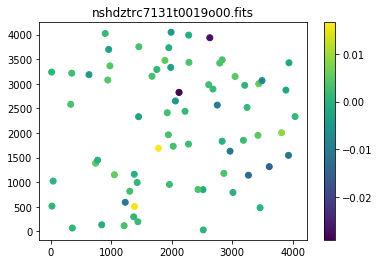

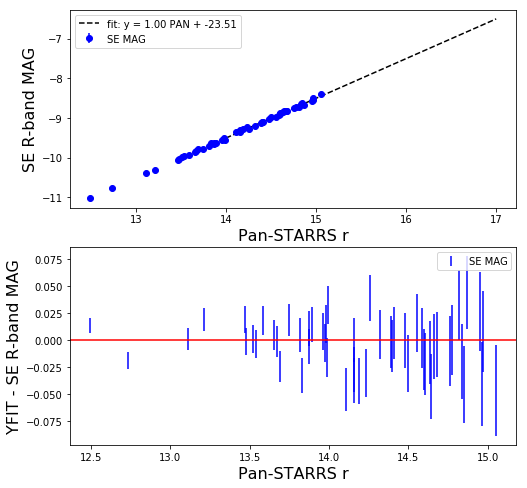

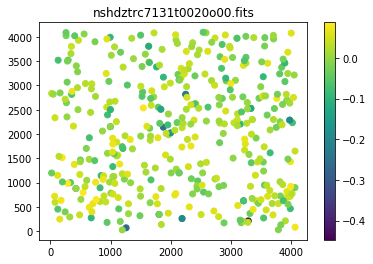

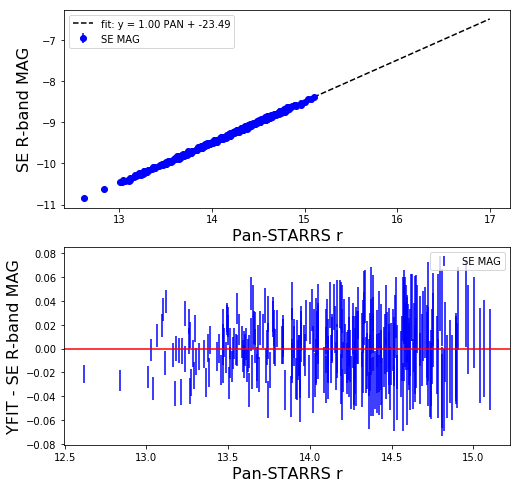

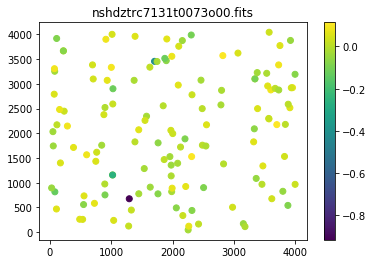

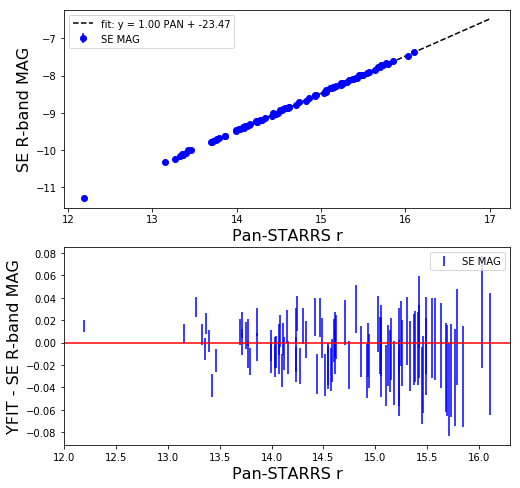

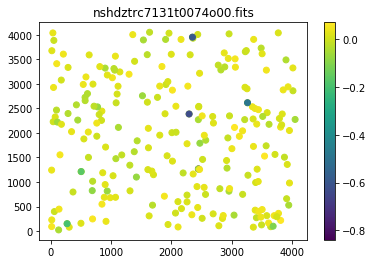

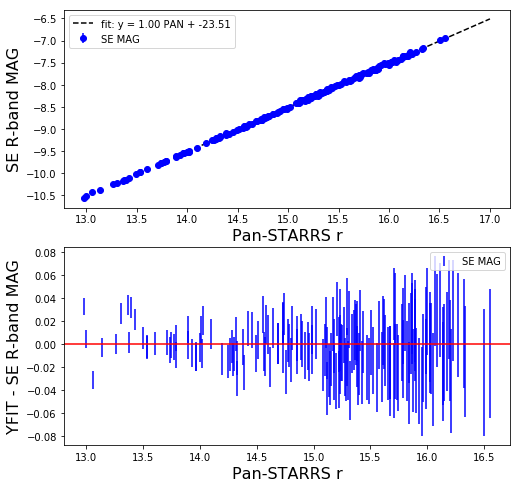

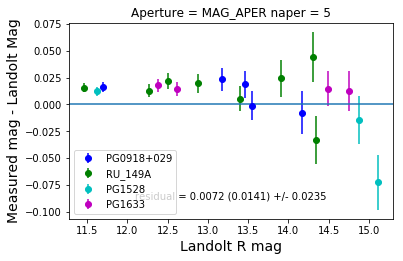

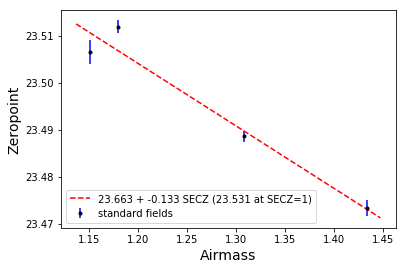

In [14]:
%run ~/github/HalphaImaging/dbug_getzp.py  --fitzp --mag 0 --naper 5 --nsigma 2.

In [16]:
plt.show()

In [24]:
zpdict

{'nshdztrc7131t0019o00.fits': 23.506521,
 'nshdztrc7131t0020o00.fits': 23.48857,
 'nshdztrc7131t0073o00.fits': 23.47263,
 'nshdztrc7131t0074o00.fits': 23.51098}

In [23]:
t=[]
for z in zpdict: t.append(zpdict[z])
print(np.mean(t))

23.494675


# Summary #


* I am using the Pan-STARRS PS1 catalog to bootstrap the zeropoint to R, r, and Halpha images.

* To start, I am using observations from 2015-04-18, taken with the HDI camera at KPNO 0.9m.
    * We have observations of four Landolt fields, with a total of 21 standards stars.

* I am evaluating the accuracy of the calibration by seeing how well we recover the magnitudes of the Landolt standards.

* Pan-STARRS photometry uses Gunn filters, and most of our KPNO data are taken through the R filter.  Therefore, I need to transform Pan-STARRS magnitudes to Johnson magnitudes.

* In trying to optimize the calibration routine, I tried four different SE magnitudes and three different Gunn to Johnson transformations.

* The SE magnitudes are: MAG_BEST, MAG_PETRO, and 2 aperture magnitudes MAG_APER4 (25 pix diameter) and MAG_APER5 (30 pix diameter).

* The SDSS Gunn to Johnson transformation doesn't work well - we get an offset of approximately 0.08 mag between our measured magnitudes and the known magnitudes for the Landolt standards.

* The transformation from Kostov & Bonev are derived from Pan-STARRS directly using 15,000 Landolt standards.  They provide two transformations to convert r to R, one that uses g-r color and the other uses r-i.  The transformation based on g-r color works better than the on based on r-i.  There is some text in the paper that suggests that g-r is better (or perhaps the r-i transformation is quadratic), so we are going with that.

* Note: I need to dig a little deeper into the Pan-STARRS magnitudes.  The paper indicates that the magnitudes are not total mag and might therefore be missing approximately 10% of light.  Presumably the Kostov & Bonev transformation accounts for this.

* New calibration from r to R using g-r colors by Kostov & Bonev (https://ui.adsabs.harvard.edu/abs/2018BlgAJ..28....3K/abstract) allows us to recover magnitudes of landolt standards with the following accuracy for   $R_{measured} - R_{landolt}$:

| Magnitude | Mean | Median | STD |Ave ZP|
|----------|------|--------|-----|----|
|MAG_APER5 | 0.0069|0.0133|0.0236|23.495 |
|MAG_APER4 | 0.0080|0.0134|0.0236|23.490 |
|MAG_BEST | 0.0035|-0.0025|0.0238 |23.430 |
|MAG_PETRO | 0.0105 |0.0087 | 0.0280| 23.462|


* Note the ZPs are different for individual images, and this is ok b/c I am not solving for an airmass term and the images are taken at different airmasses.  Each image will have its own zeropoint, based on tens to hundreds of stars in the FOV.

|Image |MAG_PETRO | MAG_APER4 | MAG_BEST |MAG_APER5 |
|------|----------|----------|----------|-----------|
|nshdztrc7131t0019o00.fits|23.477|23.504| 23.441|23.507$\pm$0.003 |
|nshdztrc7131t0020o00.fits|23.461|23.482| 23.422|23.498$\pm$0.001 |
|nshdztrc7131t0073o00.fits|23.438|23.469| 23.408|23.473$\pm$0.002 |
|nshdztrc7131t0074o00.fits|23.471|23.507| 23.450|23.512$\pm$0.001 |

* If I fit the ZP as a function of airmass for MAG_APER5 magnitudes, I get $23.66 - 0.13 \times SECZ$.  For an airmass of 1, this gives a ZP of 23.53.  I get a similar result for MAG_APER4.  The results for MAG_BEST and MAG_PETRO are below.  For comparison, Becky got 23.43 for the same date.  This is 0.1 mag brighter than my results for the aperture magnitudes, and this is significantly larger than any systematic offset that I get between $R_{measured} - R_{landolt}$.  Not sure yet how to reconcile this yet.

|Magnitude | ZP at SECZ=1 |
|----------|--------------|
| MAG_APER4 |23.53 |
|MAG_APER5 | 23.53 |
|MAG_BEST |23.47 |
|MAG_PETRO |23.50 |
|Becky (iraf) | 23.43|




## Which magnitude is best? ##

*A Uers's Guide to Stellar CCD Photometry with IRAF* by Massey and Davies (1992) suggests using an aperture that has a **radius** that is 4-5 times the stellar FWHM.

Source Extractor PHOT_APERTURES is the **diameter** of the aperture in pixels.

Thus if our seeing is typically ~3-4 pixels (or 1.2-1.6 arcsec), then we should use an aperture whose radius is 15 pixels, and whose diameter is 30 pixels.  This is now the 6th aperture listed in default.sex.HDI, and updated getzp.py to use naper=5 as the default.  This is MAG_APER5 in the discussion above.

# Next Step #

Becky and I are going to repeat this process for another night of data, to make sure we get similar results.

If the results are similar, then we can move forward with bootstrapping the photometric ZP for r, R, and Halpha from Pan-STARRS.
